In [1]:
import sys
import os
sys.path.insert(0,'../src')
sys.path.insert(0,'../data')
sys.path.insert(0,'../upload_data')
sys.path.insert(0,'../config')
sys.path.insert(0,'..')
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import etl
import json
import cleaning
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.colors as colors

In [31]:
def make_areas():
    areas = gpd.read_file('http://seshat.datasd.org/sde/pd/pd_beats_datasd.zip')
    areas = areas.drop(['objectid', 'name', 'beat', 'div'],axis = 1)
    return areas

def make_denominator(census, race):
    table = pd.pivot_table(census,index = 'serv', values = [race, 'Total'], aggfunc = sum)
    table = table.div(table.iloc[:,-1],axis = 0).drop('Total', axis = 1)
    table = table.rename(columns={race:'denominator'})
    return table

def make_numerator(df,race,start_date,end_date):
    numer = df[(df['date_stop'] >= start_date) & (df['date_stop'] <= end_date)]
    numer = pd.pivot_table(numer, index = 'service_area', columns = 'subject_race', values = 'stop_id', aggfunc = 'count',fill_value=0)
    numer['Total'] = numer.apply(sum, axis = 1)
    numer = numer.div(numer.iloc[:,-1],axis = 0)
    try:
        numer.index = numer.index.astype('int64')
    except:
        numer = numer.drop('Unknown')
        numer.index = numer.index.astype('int64')
    numer = pd.DataFrame(numer[race])
    return numer.rename(columns={race:'numerator'})

def make_proportions(df,race,start_date,end_date):
    census_fp = '../upload_data/sd_population.csv'
    census =  pd.read_csv(census_fp)
    numers = make_numerator(df,race,start_date,end_date)
    denoms = make_denominator(census, race)
    merger = numers.merge(denoms, left_index=True,right_index=True)
    return pd.DataFrame(merger.numerator/merger.denominator, columns=['prop'])

def make_heat(df,race,event,start_date,end_date,save_fig=False):
    areas = make_areas()
    props = make_proportions(df,race,start_date,end_date)
    heat = areas.merge(props, left_on='serv',right_index=True, how='outer')
    heat = heat.dissolve(by='serv',aggfunc='first').fillna(0).drop(0)
    event_y = (datetime.date.fromisoformat(start_date) + relativedelta(months = 2)).year
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.axis('off')
    ax.set_title(f'Proportion of {race} Drivers Stopped By Service Area\n Event: {event} ({event_y})'.format(race,event,event_y), fontdict={'fontsize':'15','fontweight' : '3'})
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=heat.prop.max()))
    fig.colorbar(sm)
    heat.plot(column='prop', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
    if save_fig:
        if not os.path.exists(DATA_OUTPATH):
            os.makedirs(DATA_OUTPATH, exist_ok = True)
        fig.savefig(DATA_OUTPATH + '/{r}_{e}_({e_y})'.format(r = race.replace('/', '_'),e = event,e_y = event_y))

def make_difference_heatmap(df_current,df_prior,race,event,start_date,end_date,save_fig=False):
    
    areas = make_areas()
    if datetime.date.fromisoformat(start_date).year ==2014:
        prior_start_date = (datetime.date.fromisoformat(start_date)+relativedelta(years=1)).isoformat()
        prior_end_date = (datetime.date.fromisoformat(end_date)+relativedelta(years=1)).isoformat()
    else:
        prior_start_date = (datetime.date.fromisoformat(start_date)-relativedelta(years=1)).isoformat()
        prior_end_date = (datetime.date.fromisoformat(end_date)-relativedelta(years=1)).isoformat()
    props_post = make_proportions(df_current,race,start_date,end_date)
    props_pre = make_proportions(df_prior,race,prior_start_date,prior_end_date)
    differences = props_post.subtract(props_pre)
    heat_diff = areas.merge(differences, left_on='serv',right_index=True, how='outer')
    heat_diff = heat_diff.dissolve(by='serv',aggfunc='first').fillna(0).drop(0)
    event_y = (datetime.date.fromisoformat(start_date) + relativedelta(months = 2)).year
    
    cdict = {'green':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'red': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
    GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.axis('off')
    ax.set_title(f'Change in Proportion of {race} Drivers Stopped By Service Area\n Event: {event} ({event_y})'.format(race,event,event_y), fontdict={'fontsize':'15','fontweight' : '3'})
    sm = plt.cm.ScalarMappable(cmap=GnRd, norm=plt.Normalize(vmin=-1, vmax=1,clip=True))
    fig.colorbar(sm)
    heat_diff.plot(column='prop', cmap=GnRd, linewidth=0.8, ax=ax, edgecolor='0.8')
    if save_fig:
        if not os.path.exists(DATA_OUTPATH):
            os.makedirs(DATA_OUTPATH, exist_ok = True)
        fig.savefig(DATA_OUTPATH + '/{r}_{e}_({e_y})'.format(r = race.replace('/', '_'),e = event,e_y = event_y))


In [13]:
fp_2017 = '../data/raw/STOPS_2017.csv'
test_2017 = cleaning.clean_2017(fp_2017)
test_2017.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (5,7,8,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,1444799,Moving Violation,120,Native American,Male,37.0,2017-01-01,00:03:00,N,N,NaN,N,N
1,1444867,Equipment Violation,120,White,Male,24.0,2017-01-01,19:15:00,N,N,NaN,N,N
2,1444871,Equipment Violation,310,Other,Male,32.0,2017-01-01,19:10:00,N,N,NaN,N,N
3,1444869,Moving Violation,620,White,Male,31.0,2017-01-01,19:10:00,N,N,NaN,N,N
4,1444888,Moving Violation,710,Hispanic/Latino/a,Female,67.0,2017-01-01,18:50:00,N,N,NaN,N,N


In [14]:
fp_2018 = '../data/raw/STOPS_2018-2019.csv'
test_2018 = cleaning.clean_2018_2019(fp_2018)
test_2018.head()

,stop_id,stop_cause,beat,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,2443,Reasonable Suspicion,122,120,White,Male,25,2018-07-01,00:01:37,Y,N,NaN,N,N
1,2444,Traffic Violation,121,120,White,Male,25,2018-07-01,00:03:34,N,N,NaN,N,N
2,2447,Reasonable Suspicion,822,820,Hispanic/Latino/a,Male,30,2018-07-01,00:05:43,N,N,NaN,N,N
3,2448,Traffic Violation,614,610,White,Male,23,2018-07-01,00:19:06,N,N,NaN,N,N
4,2449,Reasonable Suspicion,115,110,White,Male,25,2018-07-01,00:03:00,Y,Y,NaN,N,N


## The graph

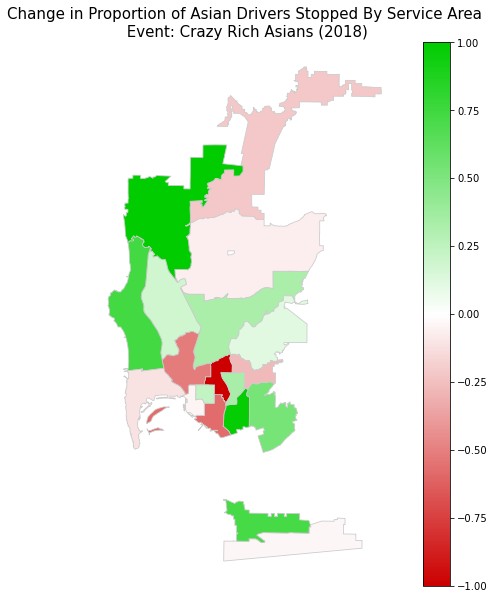

In [32]:
make_difference_heatmap(test_2018,test_2017,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15')

# The table

In [16]:
def make_difference_heatmap_table(df_current,df_prior,race,event,start_date,end_date):
    
    areas = make_areas()
    if datetime.date.fromisoformat(start_date).year ==2014:
        prior_start_date = (datetime.date.fromisoformat(start_date)+relativedelta(years=1)).isoformat()
        prior_end_date = (datetime.date.fromisoformat(end_date)+relativedelta(years=1)).isoformat()
    else:
        prior_start_date = (datetime.date.fromisoformat(start_date)-relativedelta(years=1)).isoformat()
        prior_end_date = (datetime.date.fromisoformat(end_date)-relativedelta(years=1)).isoformat()
    props_post = make_proportions(df_current,race,start_date,end_date)
    props_pre = make_proportions(df_prior,race,prior_start_date,prior_end_date)
    differences = props_post.subtract(props_pre)
    heat_diff = areas.merge(differences, left_on='serv',right_index=True, how='outer')
    heat_diff = heat_diff.dissolve(by='serv',aggfunc='first').fillna(0).drop(0)
    return heat_diff

In [18]:
non_norm=make_difference_heatmap_table(test_2018,test_2017,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15')
non_norm

,geometry,prop
serv,,
110,"POLYGON ((6279253.112 1884255.837, 6279262.023...",-0.112626
120,"POLYGON ((6252987.541 1857451.641, 6252282.413...",0.020229
230,"POLYGON ((6305786.455 1931764.390, 6305786.467...",-0.208803
240,"POLYGON ((6291971.520 1887674.568, 6291757.788...",-0.173359
310,"POLYGON ((6296145.895 1867575.086, 6296105.935...",-0.076739
320,"POLYGON ((6316141.200 1862937.460, 6316142.727...",-0.127456
430,"POLYGON ((6317292.625 1824640.012, 6317192.369...",-0.029056
440,"POLYGON ((6299388.999 1831529.000, 6299388.000...",0.077831
510,"MULTIPOLYGON (((6266866.000 1831771.472, 62668...",-0.295540


In [21]:
non_norm.prop.Normalize(vmin=-1,vmax=1,clip=True)

AttributeError: 'Series' object has no attribute 'Normalize'

AttributeError: 'NoneType' object has no attribute 'table'

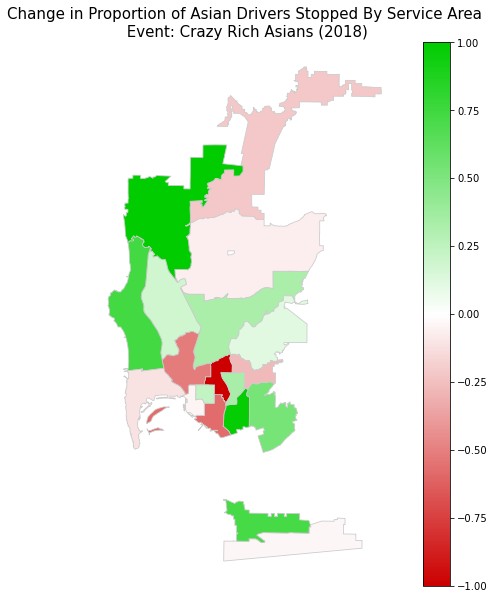

In [22]:
make_difference_heatmap(test_2018,test_2017,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15').table

In [55]:
def norm_table(df_current,df_prior,race,event,start_date,end_date):
    
    areas = make_areas()
    if datetime.date.fromisoformat(start_date).year ==2014:
        prior_start_date = (datetime.date.fromisoformat(start_date)+relativedelta(years=1)).isoformat()
        prior_end_date = (datetime.date.fromisoformat(end_date)+relativedelta(years=1)).isoformat()
    else:
        prior_start_date = (datetime.date.fromisoformat(start_date)-relativedelta(years=1)).isoformat()
        prior_end_date = (datetime.date.fromisoformat(end_date)-relativedelta(years=1)).isoformat()
    props_post = make_proportions(df_current,race,start_date,end_date)
    props_pre = make_proportions(df_prior,race,prior_start_date,prior_end_date)
    differences = props_post.subtract(props_pre)
    heat_diff = areas.merge(differences, left_on='serv',right_index=True, how='outer')
    heat_diff = heat_diff.dissolve(by='serv',aggfunc='first').fillna(0).drop(0)
    event_y = (datetime.date.fromisoformat(start_date) + relativedelta(months = 2)).year
    
    cdict = {'green':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'red': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
    GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.axis('off')
    ax.set_title(f'Change in Proportion of {race} Drivers Stopped By Service Area\n Event: {event} ({event_y})'.format(race,event,event_y), fontdict={'fontsize':'15','fontweight' : '3'})
    heat_diff.plot(column='prop', cmap=GnRd, linewidth=0.8, ax=ax,
                   edgecolor='0.8', vmin=-.5, vmax=.5, legend=True)

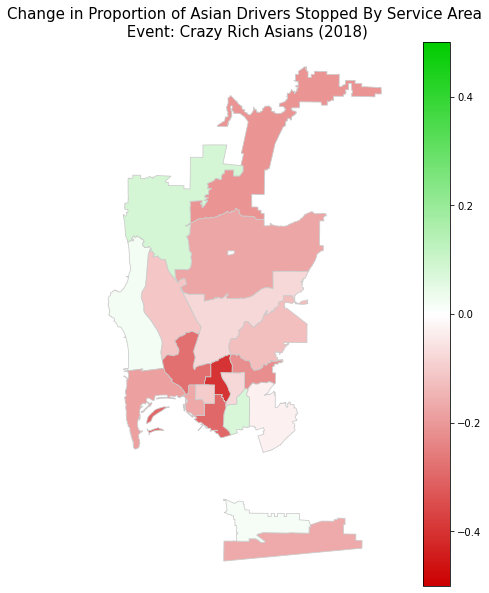

In [56]:
norm_table(test_2018,test_2017,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15')

In [57]:
fp_2016 = '../data/raw/STOPS_2016.csv'
test_2016 = cleaning.clean_2014_2016(fp_2016)

In [ ]:
norm_table(test_2018,test_2017,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15')